Using device: cuda
L1 Error :  7.667450596313049


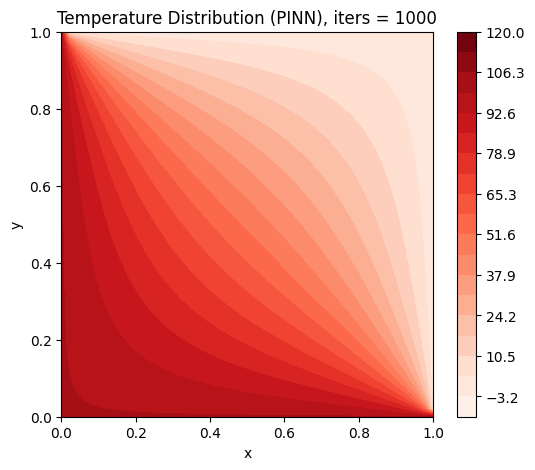

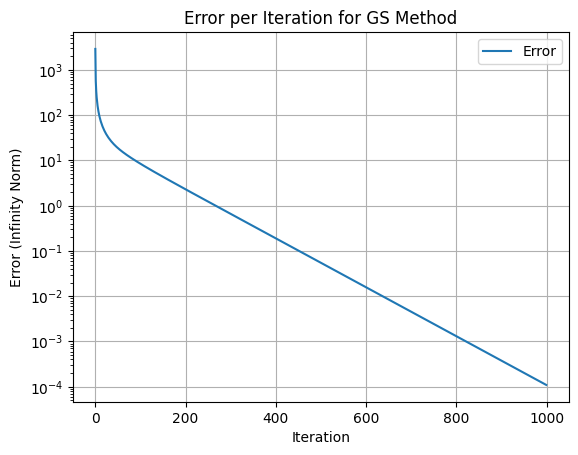

Epoch 0, Loss: 3.132199360988963e-11
Epoch 1, Loss: 3.3138759097939285e-11
Epoch 2, Loss: 3.291748471023759e-11
Epoch 3, Loss: 3.532969750086323e-11
Epoch 4, Loss: 3.2075911371443055e-11


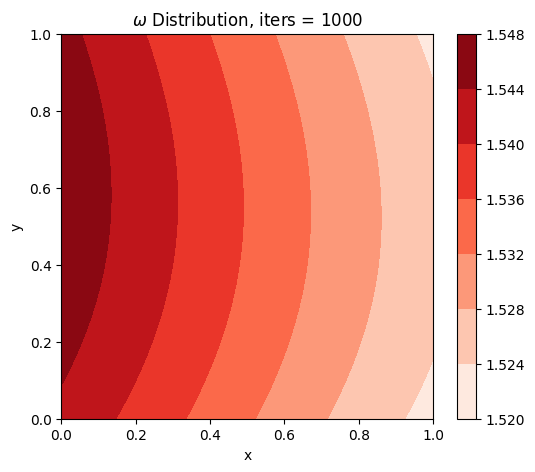

In [1]:
"""
Optimal Over-relaxation parameter discovery, iters = 1000
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd
torch.autograd.set_detect_anomaly(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)
print(f'Using device: {device}')

def sor(Nx, Ny, omega, max_iter=1000, tol=1e-6):
    T = np.zeros((Nx, Ny))
    T[:, 0] = 100.0  # Left boundary
    T[0, :] = 100.0  # Bottom boundary
    dx = 1.0 / (Nx - 1)
    dy = 1.0 / (Ny - 1)
    
    errors = []  # List to store the error at each iteration
    asymptotic_iter = None  # Variable to store the iteration when asymptotic convergence is reached
    
    for k in range(max_iter):
        T_old = T.copy()
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                T_new = 0.25 * (T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1])
                T[i, j] = (1 - omega) * T[i, j] + omega * T_new
        
        # Compute the error as the infinity norm of the difference between T and T_old
        error = np.linalg.norm(T - T_old, ord=np.inf)
        errors.append(error)
        
        if k > 1:
            # Check if the error reduction rate has stabilized
            error_reduction_rate = errors[-2] / errors[-1]
            if asymptotic_iter is None and abs(error_reduction_rate - 1) < tol:
                asymptotic_iter = k
        
        if error < tol:
            break
    
    return T_old, T, errors, asymptotic_iter

Nx, Ny = 50, 50
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)
omega = 1.5 # Relaxation factor
T_k, T_kp1, errors, asymptotic_iter = sor(Nx, Ny, omega, max_iter=1000)
print("L1 Error : ",np.mean(errors))

levels = np.linspace(-10, 120, 20)
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, T_k, cmap='Reds', levels=levels)
plt.colorbar()
plt.title('Temperature Distribution (PINN), iters = 1000')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Plotting the error per iteration
plt.figure()
plt.plot(errors, label='Error')
if asymptotic_iter is not None:
    plt.axvline(x=asymptotic_iter, color='r', linestyle='--', label='Asymptotic Convergence')
plt.yscale('log')  # Use logarithmic scale for better visualization of error reduction
plt.xlabel('Iteration')
plt.ylabel('Error (Infinity Norm)')
plt.title('Error per Iteration for GS Method')
plt.legend()
plt.grid(True)
plt.show()

class OmegaNet(nn.Module):
    def __init__(self):
        super(OmegaNet, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)  # Sigmoid activation to constrain output to (0, 1)
        x = 1 + x  # Scale output to (1, 2)
        return x

class PINNLoss(nn.Module):
    def __init__(self, device):
        super(PINNLoss, self).__init__()
        self.device = device

    def forward(self, net, collocation_points, T_old, T_new):
        # Collocation points loss (PDE loss)
        collocation_points.requires_grad = True
        omega = net(collocation_points).reshape(50, 50)
        T = torch.tensor(T_old, device=self.device, dtype=torch.float32)
        T_new_tensor = torch.tensor(T_new, device=self.device, dtype=torch.float32)
        
        T_updated = T.clone()  # Create a copy of T to avoid in-place operations
        
        for i in range(1, 49):
            for j in range(1, 49):
                T_new_val = 0.25 * (T_updated[i+1, j] + T_updated[i-1, j] + T_updated[i, j+1] + T_updated[i, j-1])
                T_updated[i, j] = (1 - omega[i, j]) * T[i, j] + omega[i, j] * T_new_val

        loss = nn.MSELoss()
        tLoss = loss(T_updated.flatten(), T_new_tensor.flatten())
        return tLoss

def train(net, loss_fn, optimizer, num_epochs, collocation_points, T_old, T_new):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_fn(net, collocation_points, T_old, T_new)
        loss.backward()
        optimizer.step()
        
        # if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]

collocation_points = torch.tensor(np.hstack((X_flat, Y_flat)), dtype=torch.float32, device=device)

net = OmegaNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
loss_fn = PINNLoss(device)

num_epochs = 5
train(net, loss_fn, optimizer, num_epochs, collocation_points, T_k, T_kp1)

omega = net(collocation_points).detach().cpu().numpy().reshape(Nx, Ny)

plt.figure(figsize=(6, 5))
plt.contourf(X, Y, omega, cmap='Reds')
plt.colorbar()
plt.title(r'$\omega$ Distribution, iters = 1000')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Using device: cuda
L1 Error :  851.3778205634395


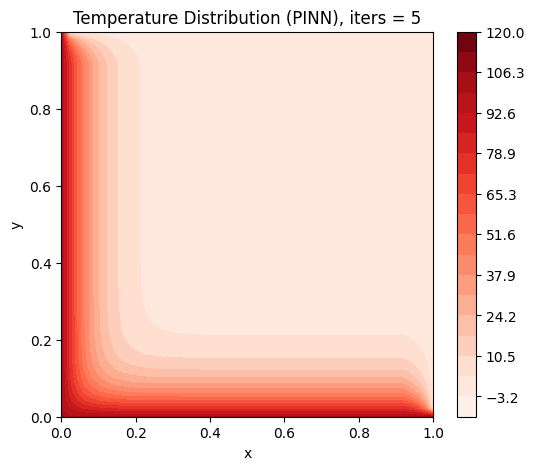

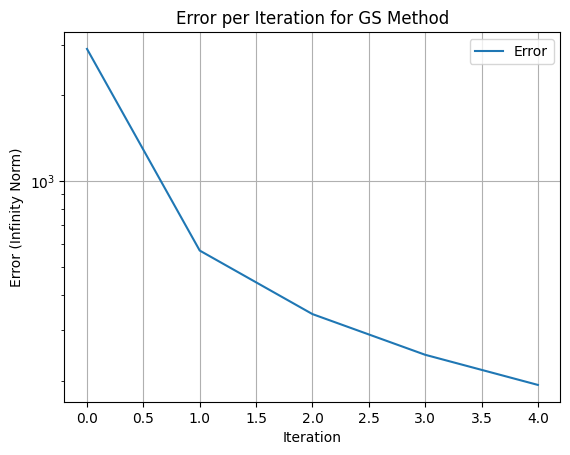

Epoch 0, Loss: 0.024428557604551315
Epoch 1, Loss: 0.25978609919548035
Epoch 2, Loss: 0.10972714424133301
Epoch 3, Loss: 0.0005853786133229733
Epoch 4, Loss: 0.11010836064815521


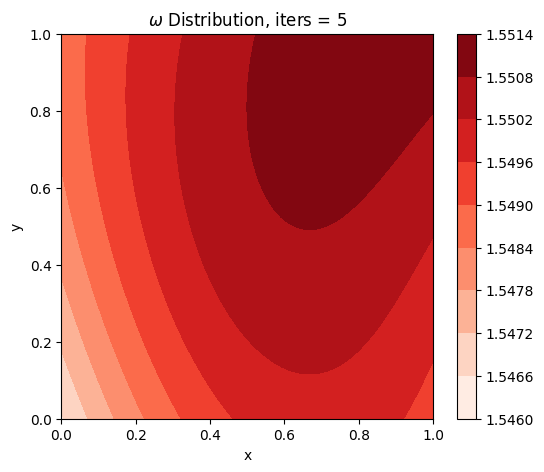

In [2]:
"""
Optimal Over-relaxation parameter discovery, iters = 5
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd
torch.autograd.set_detect_anomaly(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)
print(f'Using device: {device}')

def sor(Nx, Ny, omega, max_iter=1000, tol=1e-6):
    T = np.zeros((Nx, Ny))
    T[:, 0] = 100.0  # Left boundary
    T[0, :] = 100.0  # Bottom boundary
    dx = 1.0 / (Nx - 1)
    dy = 1.0 / (Ny - 1)
    
    errors = []  # List to store the error at each iteration
    asymptotic_iter = None  # Variable to store the iteration when asymptotic convergence is reached
    
    for k in range(max_iter):
        T_old = T.copy()
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                T_new = 0.25 * (T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1])
                T[i, j] = (1 - omega) * T[i, j] + omega * T_new
        
        # Compute the error as the infinity norm of the difference between T and T_old
        error = np.linalg.norm(T - T_old, ord=np.inf)
        errors.append(error)
        
        if k > 1:
            # Check if the error reduction rate has stabilized
            error_reduction_rate = errors[-2] / errors[-1]
            if asymptotic_iter is None and abs(error_reduction_rate - 1) < tol:
                asymptotic_iter = k
        
        if error < tol:
            break
    
    return T_old, T, errors, asymptotic_iter

Nx, Ny = 50, 50
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)
omega = 1.5 # Relaxation factor
T_k, T_kp1, errors, asymptotic_iter = sor(Nx, Ny, omega, max_iter=5)
print("L1 Error : ",np.mean(errors))

levels = np.linspace(-10, 120, 20)
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, T_k, cmap='Reds', levels=levels)
plt.colorbar()
plt.title('Temperature Distribution (PINN), iters = 5')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Plotting the error per iteration
plt.figure()
plt.plot(errors, label='Error')
if asymptotic_iter is not None:
    plt.axvline(x=asymptotic_iter, color='r', linestyle='--', label='Asymptotic Convergence')
plt.yscale('log')  # Use logarithmic scale for better visualization of error reduction
plt.xlabel('Iteration')
plt.ylabel('Error (Infinity Norm)')
plt.title('Error per Iteration for GS Method')
plt.legend()
plt.grid(True)
plt.show()

class OmegaNet(nn.Module):
    def __init__(self):
        super(OmegaNet, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)  # Sigmoid activation to constrain output to (0, 1)
        x = 1 + x  # Scale output to (1, 2)
        return x

class PINNLoss(nn.Module):
    def __init__(self, device):
        super(PINNLoss, self).__init__()
        self.device = device

    def forward(self, net, collocation_points, T_old, T_new):
        # Collocation points loss (PDE loss)
        collocation_points.requires_grad = True
        omega = net(collocation_points).reshape(50, 50)
        T = torch.tensor(T_old, device=self.device, dtype=torch.float32)
        T_new_tensor = torch.tensor(T_new, device=self.device, dtype=torch.float32)
        
        T_updated = T.clone()  # Create a copy of T to avoid in-place operations
        
        for i in range(1, 49):
            for j in range(1, 49):
                T_new_val = 0.25 * (T_updated[i+1, j] + T_updated[i-1, j] + T_updated[i, j+1] + T_updated[i, j-1])
                T_updated[i, j] = (1 - omega[i, j]) * T[i, j] + omega[i, j] * T_new_val

        loss = nn.MSELoss()
        tLoss = loss(T_updated.flatten(), T_new_tensor.flatten())
        return tLoss

def train(net, loss_fn, optimizer, num_epochs, collocation_points, T_old, T_new):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_fn(net, collocation_points, T_old, T_new)
        loss.backward()
        optimizer.step()
        
        # if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]

collocation_points = torch.tensor(np.hstack((X_flat, Y_flat)), dtype=torch.float32, device=device)

net = OmegaNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
loss_fn = PINNLoss(device)

num_epochs = 5
train(net, loss_fn, optimizer, num_epochs, collocation_points, T_k, T_kp1)

omega = net(collocation_points).detach().cpu().numpy().reshape(Nx, Ny)

plt.figure(figsize=(6, 5))
plt.contourf(X, Y, omega, cmap='Reds')
plt.colorbar()
plt.title(r'$\omega$ Distribution, iters = 5')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Using device: cuda
L1 Error :  37.41215493243833


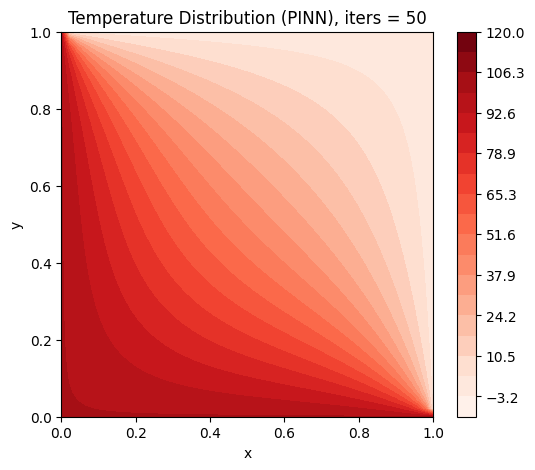

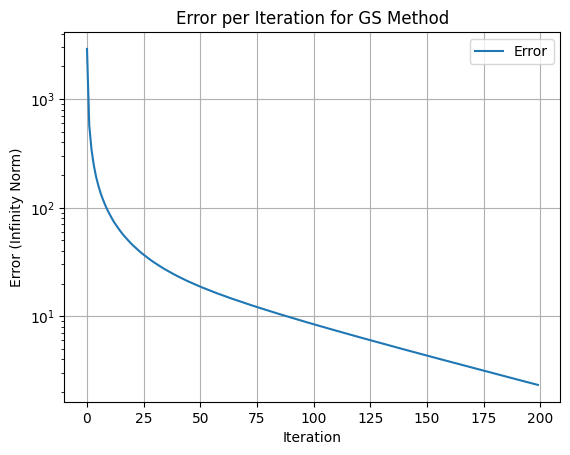

Epoch 0, Loss: 6.582091373275034e-06
Epoch 1, Loss: 0.0001397053711116314
Epoch 2, Loss: 5.443707050289959e-05
Epoch 3, Loss: 1.6556599575778819e-06
Epoch 4, Loss: 6.33553572697565e-05


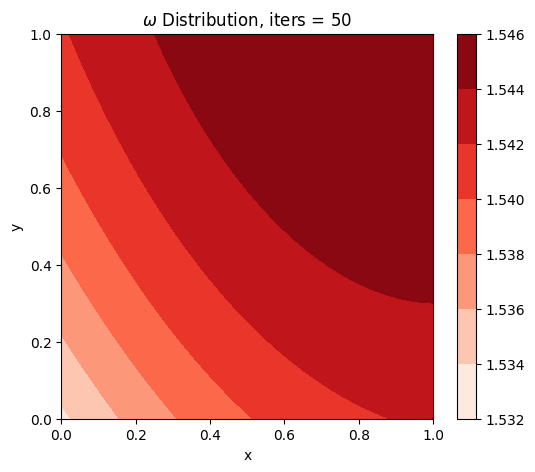

In [3]:
"""
Optimal Over-relaxation parameter discovery, iters = 50
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.autograd
torch.autograd.set_detect_anomaly(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)
print(f'Using device: {device}')

def sor(Nx, Ny, omega, max_iter=1000, tol=1e-6):
    T = np.zeros((Nx, Ny))
    T[:, 0] = 100.0  # Left boundary
    T[0, :] = 100.0  # Bottom boundary
    dx = 1.0 / (Nx - 1)
    dy = 1.0 / (Ny - 1)
    
    errors = []  # List to store the error at each iteration
    asymptotic_iter = None  # Variable to store the iteration when asymptotic convergence is reached
    
    for k in range(max_iter):
        T_old = T.copy()
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                T_new = 0.25 * (T[i+1, j] + T[i-1, j] + T[i, j+1] + T[i, j-1])
                T[i, j] = (1 - omega) * T[i, j] + omega * T_new
        
        # Compute the error as the infinity norm of the difference between T and T_old
        error = np.linalg.norm(T - T_old, ord=np.inf)
        errors.append(error)
        
        if k > 1:
            # Check if the error reduction rate has stabilized
            error_reduction_rate = errors[-2] / errors[-1]
            if asymptotic_iter is None and abs(error_reduction_rate - 1) < tol:
                asymptotic_iter = k
        
        if error < tol:
            break
    
    return T_old, T, errors, asymptotic_iter

Nx, Ny = 50, 50
x = np.linspace(0, 1, Nx)
y = np.linspace(0, 1, Ny)
X, Y = np.meshgrid(x, y)
omega = 1.5 # Relaxation factor
T_k, T_kp1, errors, asymptotic_iter = sor(Nx, Ny, omega, max_iter=200)
print("L1 Error : ",np.mean(errors))

levels = np.linspace(-10, 120, 20)
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, T_k, cmap='Reds', levels=levels)
plt.colorbar()
plt.title('Temperature Distribution (PINN), iters = 50')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Plotting the error per iteration
plt.figure()
plt.plot(errors, label='Error')
if asymptotic_iter is not None:
    plt.axvline(x=asymptotic_iter, color='r', linestyle='--', label='Asymptotic Convergence')
plt.yscale('log')  # Use logarithmic scale for better visualization of error reduction
plt.xlabel('Iteration')
plt.ylabel('Error (Infinity Norm)')
plt.title('Error per Iteration for GS Method')
plt.legend()
plt.grid(True)
plt.show()

class OmegaNet(nn.Module):
    def __init__(self):
        super(OmegaNet, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)  # Sigmoid activation to constrain output to (0, 1)
        x = 1 + x  # Scale output to (1, 2)
        return x

class PINNLoss(nn.Module):
    def __init__(self, device):
        super(PINNLoss, self).__init__()
        self.device = device

    def forward(self, net, collocation_points, T_old, T_new):
        # Collocation points loss (PDE loss)
        collocation_points.requires_grad = True
        omega = net(collocation_points).reshape(50, 50)
        T = torch.tensor(T_old, device=self.device, dtype=torch.float32)
        T_new_tensor = torch.tensor(T_new, device=self.device, dtype=torch.float32)
        
        T_updated = T.clone()  # Create a copy of T to avoid in-place operations
        
        for i in range(1, 49):
            for j in range(1, 49):
                T_new_val = 0.25 * (T_updated[i+1, j] + T_updated[i-1, j] + T_updated[i, j+1] + T_updated[i, j-1])
                T_updated[i, j] = (1 - omega[i, j]) * T[i, j] + omega[i, j] * T_new_val

        loss = nn.MSELoss()
        tLoss = loss(T_updated.flatten(), T_new_tensor.flatten())
        return tLoss

def train(net, loss_fn, optimizer, num_epochs, collocation_points, T_old, T_new):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        loss = loss_fn(net, collocation_points, T_old, T_new)
        loss.backward()
        optimizer.step()
        
        # if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

X_flat = X.flatten()[:, None]
Y_flat = Y.flatten()[:, None]

collocation_points = torch.tensor(np.hstack((X_flat, Y_flat)), dtype=torch.float32, device=device)

net = OmegaNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.01)
loss_fn = PINNLoss(device)

num_epochs = 5
train(net, loss_fn, optimizer, num_epochs, collocation_points, T_k, T_kp1)

omega = net(collocation_points).detach().cpu().numpy().reshape(Nx, Ny)

plt.figure(figsize=(6, 5))
plt.contourf(X, Y, omega, cmap='Reds')
plt.colorbar()
plt.title(r'$\omega$ Distribution, iters = 50')
plt.xlabel('x')
plt.ylabel('y')
plt.show()